**Import all the required libraries**

In [ ]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

**Load dataset from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import the train dataset and check the features**

In [ ]:
df_train_data_pathway = '/content/drive/My Drive/Project_Dataset/drugsComTrain_raw.csv'
df_train_data = pd.read_csv(df_train_data_pathway)
df_train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


**Import the test dataset and check the features**

In [ ]:
df_test_data_pathway = '/content/drive/My Drive/Project_Dataset/drugsComTest_raw.csv'
df_test_data = pd.read_csv(df_test_data_pathway)
df_test_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


**Load spacy model for preprocessing the dataset**

In [ ]:
nlp = spacy.load('en_core_web_sm')

**Combine the train and test datasets and check the shape**

In [ ]:
merge = [df_train_data,df_test_data]
df_review_data= pd.concat(merge,ignore_index=True)

df_review_data.shape

(215063, 7)

**Randomly select only 10,000 samples for analysis**

In [ ]:
df_review_data = df_review_data.sample(n=10000, random_state=42)
df_review_data.shape

(10000, 7)

**Check for null values and features with the highest number of null values**

In [ ]:
df_review_data.isnull().sum()


,0
uniqueID,0
drugName,0
condition,1194
review,0
rating,0
date,0
usefulCount,0


**Drop the null values**

In [ ]:
df_review_data.dropna(inplace=True, axis=0)

**A function to preprocess the text reviews**

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    doc = nlp(text.lower())
    text = text.replace("n't", " not")
    return ' '.join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)


**Applying the function on the review feature**

In [ ]:
df_review_data['cleaned_feedback'] = df_review_data['review'].apply(preprocess_text)

**Checking the preprocessed data using the head function**

In [ ]:
df_review_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_feedback
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,effect combination bystolic mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv concerned begi...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,oral contraceptive pill cycle happy light pe...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,time form birth control m glad go patch mont...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxone completely turn life feel healthy m...
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,nd day mg start work rock hard erection experi...
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,pull cumme bit take plan b hour later take p...
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,abilify change life hope zoloft clonidine star...
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11,ve problem keppera constant shake arm am...
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,pill year doctor change rx chateal effective h...


**A function to apply sentiment analysis using textblob**

In [ ]:
def analyze_sentiment(cleaned_feedback):
    blob = TextBlob(cleaned_feedback)
    return blob.sentiment.polarity, blob.sentiment.subjectivity


df_review_data[['polarity', 'subjectivity_score']] = df_review_data['cleaned_feedback'].apply(lambda x: pd.Series(analyze_sentiment(x)))


**checked the analysed data**

In [ ]:
df_review_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_feedback,polarity,subjectivity_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,effect combination bystolic mg fish oil,0.000000,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv concerned begi...,0.164028,0.577639
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,oral contraceptive pill cycle happy light pe...,0.093939,0.470455
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,time form birth control m glad go patch mont...,0.340000,0.730000
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxone completely turn life feel healthy m...,0.242333,0.469667
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,nd day mg start work rock hard erection experi...,-0.031944,0.290278
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,pull cumme bit take plan b hour later take p...,0.111111,0.166667
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,abilify change life hope zoloft clonidine star...,-0.007812,0.321354
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11,ve problem keppera constant shake arm am...,0.200000,0.516667
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,pill year doctor change rx chateal effective h...,-0.013889,0.405556


**A function to categorize the sentiments using the polarity/sentiment score**

In [ ]:
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df_review_data['sentiment'] = df_review_data['polarity'].apply(classify_sentiment)


**Checking the categorized dataset**

In [ ]:
df_review_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_feedback,polarity,subjectivity_score,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,effect combination bystolic mg fish oil,0.000000,0.000000,Neutral
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv concerned begi...,0.164028,0.577639,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,oral contraceptive pill cycle happy light pe...,0.093939,0.470455,Neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,time form birth control m glad go patch mont...,0.340000,0.730000,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxone completely turn life feel healthy m...,0.242333,0.469667,Positive
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,nd day mg start work rock hard erection experi...,-0.031944,0.290278,Neutral
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,pull cumme bit take plan b hour later take p...,0.111111,0.166667,Positive
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,abilify change life hope zoloft clonidine star...,-0.007812,0.321354,Neutral
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11,ve problem keppera constant shake arm am...,0.200000,0.516667,Positive
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,pill year doctor change rx chateal effective h...,-0.013889,0.405556,Neutral


**Converting the rating feature to a binary feature (0s and 1s)**

In [ ]:
df_review_data['sentiments'] = df_review_data["rating"].apply(lambda x: 1 if x >= 5 else 0)

**EXPLORATORY AND VISUALIZATION OF THE RESULT OF THE PERFORMED SENTIMENT ANALYSIS ON THE DATASET**

**Plot the distribution of sentiment scores**

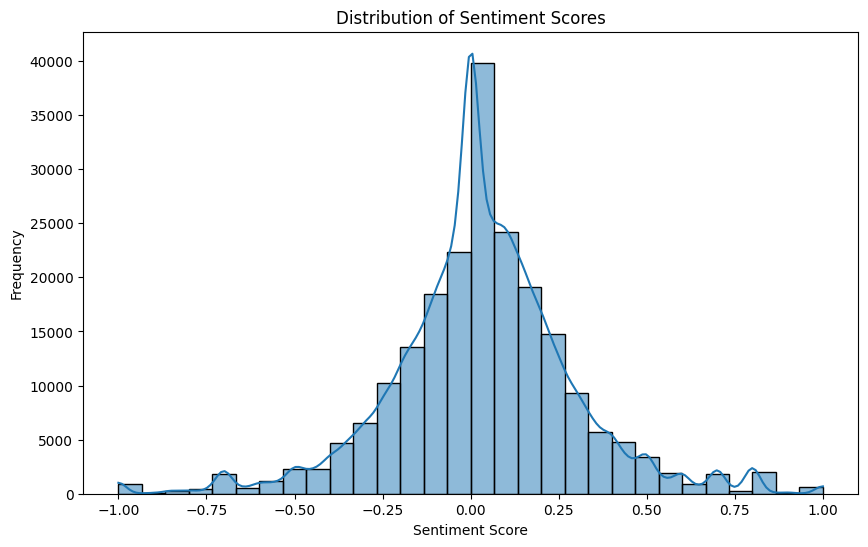

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_review_data['polarity'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

**Plot the distribution of sentiment categories**

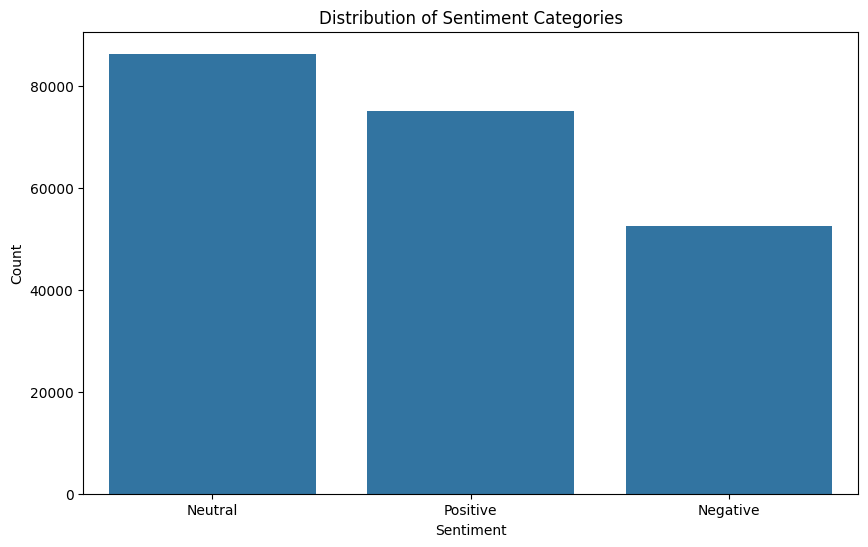

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_review_data, x='sentiment')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

**Correlating between specific drugs and sentiment**

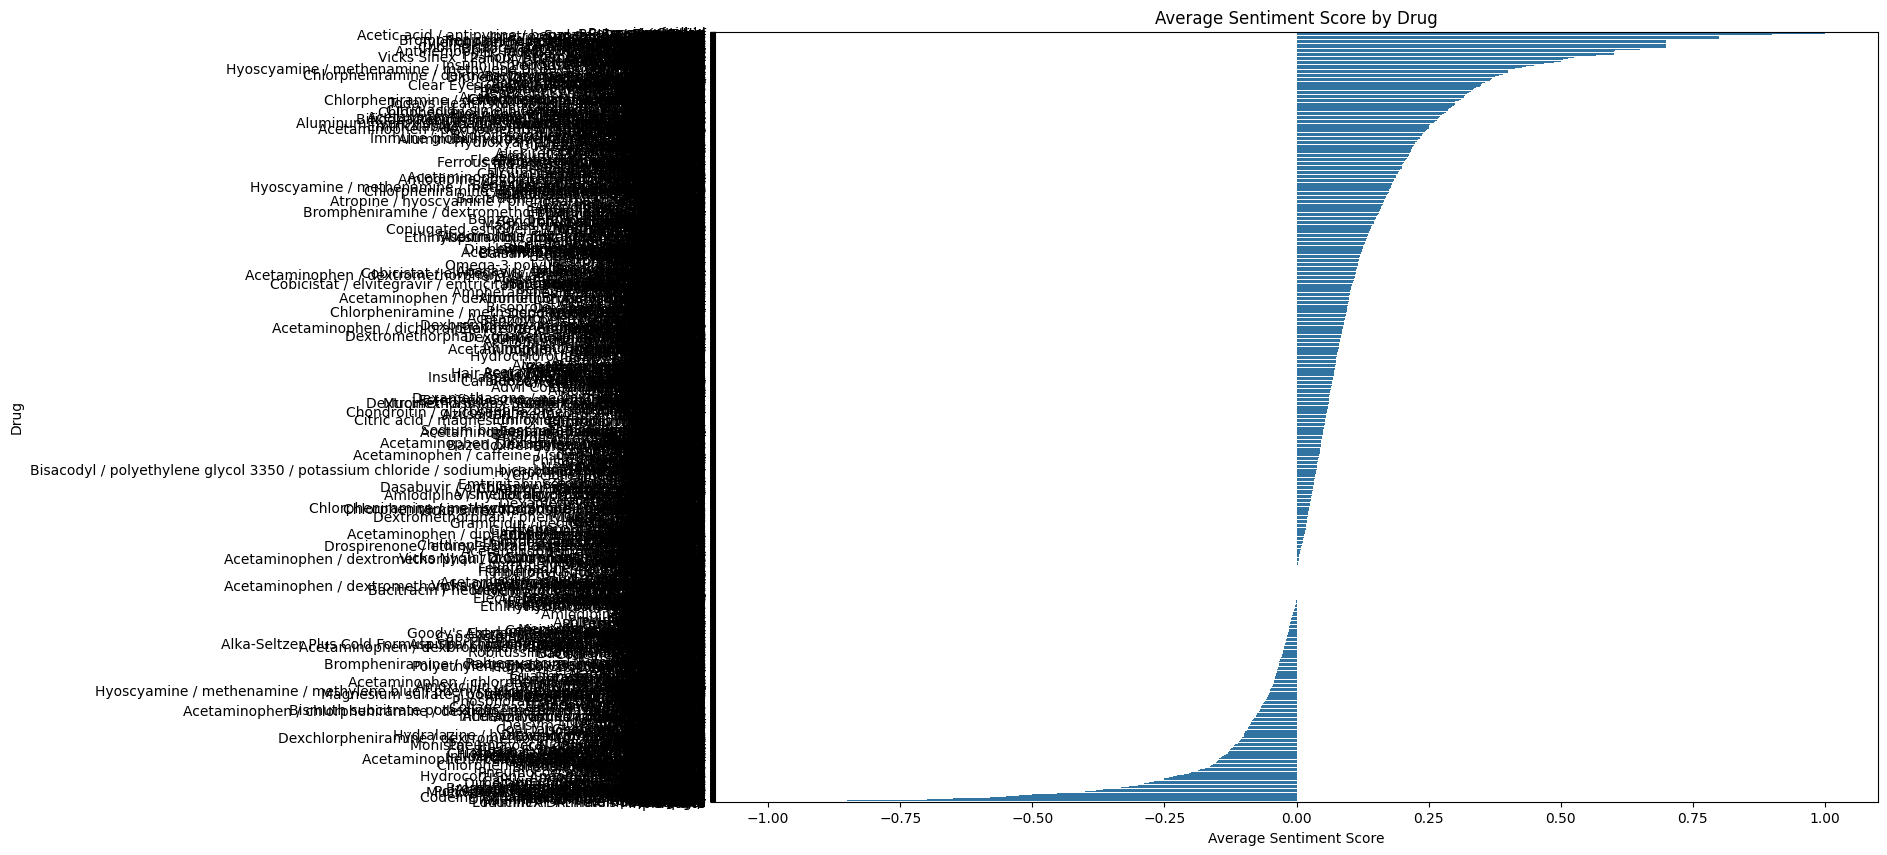

In [ ]:
drug_sentiment = df_review_data.groupby('drugName')['polarity'].mean().reset_index()
drug_sentiment = drug_sentiment.sort_values(by='polarity', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(data=drug_sentiment, x='polarity', y='drugName')
plt.title('Average Sentiment Score by Drug')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Drug')
plt.show()

**Generating Positive and Negative feedback Word Clouds and plots**

In [ ]:
positive_feedback = ' '.join(df_review_data[df_review_data['sentiment'] == 'Positive']['cleaned_feedback'])
negative_feedback = ' '.join(df_review_data[df_review_data['sentiment'] == 'Negative']['cleaned_feedback'])

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_feedback)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_feedback)


**Plot the Positive word clouds**

(-0.5, 799.5, 399.5, -0.5)

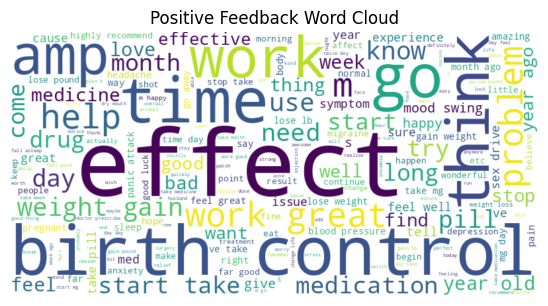

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Feedback Word Cloud')
plt.axis('off')

**Plot the Negative word clouds**

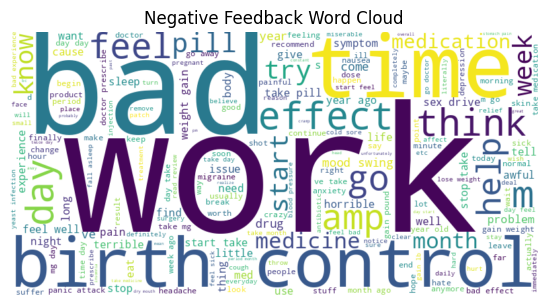

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Feedback Word Cloud')
plt.axis('off')

plt.show()

**A function to analyze common themes in feedback**

In [ ]:
def get_common_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    wordsBag = vec.transform(corpus)
    wordsSum = wordsBag.sum(axis=0)
    wordsFreq = [(word, wordsSum[0, idx]) for word, idx in vec.vocabulary_.items()]
    wordsFreq = sorted(wordsFreq, key = lambda x: x[1], reverse=True)
    return wordsFreq[:n]


**Applying the get function on the sentiment and the pre-processed review**

In [ ]:
positive_common_words = get_common_words(df_review_data[df_review_data['sentiment'] == 'Positive']['cleaned_feedback'])
negative_common_words = get_common_words(df_review_data[df_review_data['sentiment'] == 'Negative']['cleaned_feedback'])

**Printing the top 10 positive and negative feedbackts**

In [ ]:
print("Top 10 words in positive feedback:")
print(positive_common_words)

print("\nTop 10 words in negative feedback:")
print(negative_common_words)

Top 10 words in positive feedback:
[('day', 39559), ('year', 32268), ('work', 31844), ('month', 29186), ('feel', 28385), ('effect', 25317), ('week', 24457), ('start', 24229), ('good', 23237), ('mg', 21022)]

Top 10 words in negative feedback:
[('day', 34274), ('bad', 30318), ('feel', 25402), ('month', 23247), ('week', 19465), ('start', 19241), ('pain', 17988), ('year', 17761), ('time', 17605), ('effect', 17453)]


**CHECKING FOR UNBALANCED CLASSES**

**functions to calculate, visualize and print the distribution of classes**

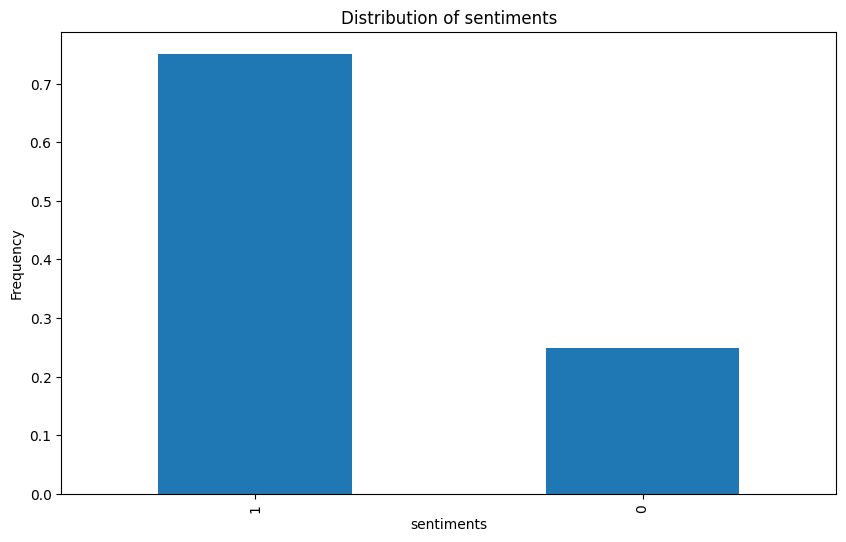

sentiments
1    0.750988
0    0.249012
Name: proportion, dtype: float64


In [ ]:
def calculate_distribution(df_review_data, sentiments):
    return df_review_data[sentiments].value_counts(normalize=True)

def visualize_distribution(distribution, sentiments):
    plt.figure(figsize=(10, 6))
    distribution.plot(kind='bar')
    plt.title(f'Distribution of {sentiments}')
    plt.xlabel(sentiments)
    plt.ylabel('Frequency')
    plt.show()

def main():

    distribution = calculate_distribution(df_review_data, 'sentiments')
    visualize_distribution(distribution, 'sentiments')
    print(distribution)

if __name__ == "__main__":
    main()


**To print the class distribution**

In [ ]:
class_distribution = df_review_data['sentiments'].value_counts()
print("Class distribution using value_counts:")
print(class_distribution)

Class distribution using value_counts:
sentiments
1    160613
0     53256
Name: count, dtype: int64


**To check class distribution using Counter**

In [ ]:
class_distribution_counter = Counter(df_review_data['sentiments'])
print("\nClass distribution using Counter:")
print(class_distribution_counter)


Class distribution using Counter:
Counter({1: 160613, 0: 53256})


**To visualize class distribution using matplotlib**

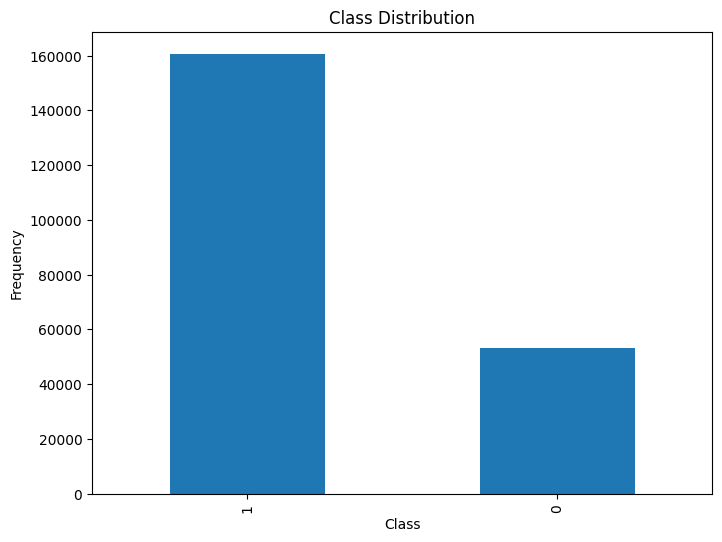

In [ ]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

**To visualize class distribution using seaborn**

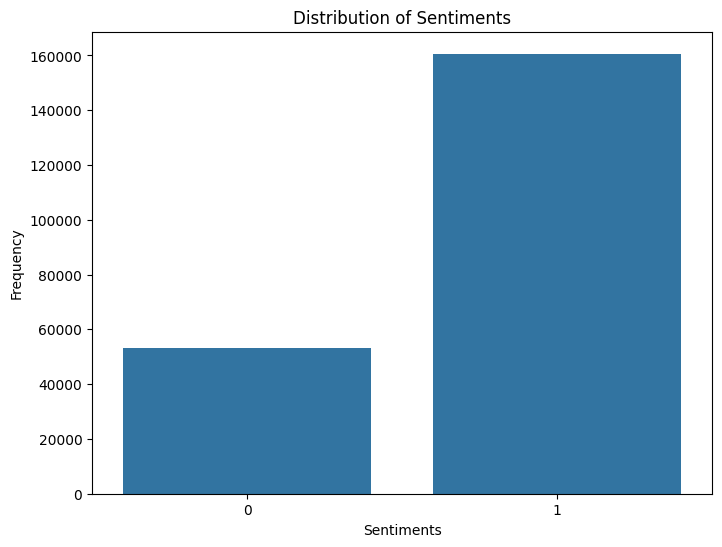

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiments', data=df_review_data)
plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiments')
plt.show()

**To save the sentiments column with a variable**

In [ ]:
sentiments = df_review_data['sentiments']

**To perform feature engineering using tfidfvectorizer**

In [ ]:
vectorizer = TfidfVectorizer()
df_review = vectorizer.fit_transform(df_review_data['cleaned_feedback'])
df_review.shape

(213869, 69188)

**To split the dataset into train and test sets**

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(df_review,sentiments,test_size=0.33,random_state=42)

**To balance the unbalanced classes**

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)

# to check the distribution of classes after applying SMOTE
print(f"Original class distribution: {Counter(Y_train)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")


Original class distribution: Counter({1: 107746, 0: 35546})
Resampled class distribution: Counter({1: 107746, 0: 107746})


**Visualization of the balanced class distribution after SMOTE**

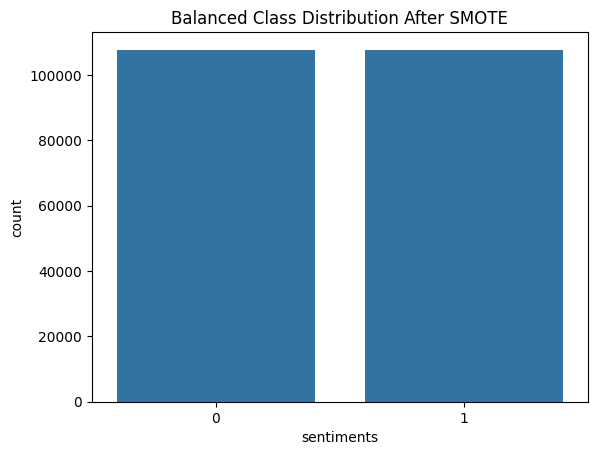

In [ ]:
sns.countplot(x=y_resampled)
plt.title('Balanced Class Distribution After SMOTE')
plt.show()

**Resaving the sampled data**

In [ ]:
X_train_main = X_resampled
Y_train_main = y_resampled

**IMPLEMENTATION OF THE MACHINE LEARNING TRAINING MODEL FROM SCRATCH**

**Multinomial Naive Bayes class**

In [ ]:
class MultinomialNaiveBayes(BaseEstimator, ClassifierMixin):
    #function to initialize
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    #function fit to calulate the prior and likelihood
    def fit(self, X_train, Y_train):
        noOfDocs, noOfWords = X_train.shape
        self.classes_ = np.unique(Y_train)
        noOfClasses = len(self.classes_)

        self.class_prior = np.zeros(noOfClasses)
        for index, cls in enumerate(self.classes_):
            self.class_prior[index] = np.sum(Y_train == cls) / noOfDocs

        self.conditional_prob = np.zeros((noOfClasses, noOfWords))
        for index, cls in enumerate(self.classes_):
            xTrain_cls = X_train[Y_train == cls]
            class_word_count = xTrain_cls.sum(axis=0)
            total_class_word_count = class_word_count.sum()
            self.conditional_prob[index, :] = (class_word_count + self.alpha) / (total_class_word_count + noOfWords)  # Laplace smoothing

    #function predict to test the trained data
    def predict(self, X_train):
        noOfDocs = X_train.shape[0]
        probabilityLog = np.zeros((noOfDocs, len(self.classes_)))

        for index, cls in enumerate(self.classes_):
            probabilityLogCls = np.log(self.class_prior[index])
            probabilityLogWords = X_train @ np.log(self.conditional_prob[index, :].T)
            probabilityLog[:, index] = probabilityLogCls + probabilityLogWords

        return self.classes_[np.argmax(probabilityLog, axis=1)]

    #function to evaluate the predicted data using ROC and AUC
    def predict_proba(self, X_train):
        noOfDocs = X_train.shape[0]
        probabilityLog = np.zeros((noOfDocs, len(self.classes_)))

        for index, cls in enumerate(self.classes_):
            probabilityLogCls = np.log(self.class_prior[index])
            probabilityLogWords = X_train @ np.log(self.conditional_prob[index, :].T)
            probabilityLog[:, index] = probabilityLogCls + probabilityLogWords

        return np.exp(probabilityLog - np.max(probabilityLog, axis=1, keepdims=True))


**Creating an object instance of the class MultinomialNaiveBayes() and training the dataset**

In [ ]:
multinomialNB = MultinomialNaiveBayes()

multinomialNB.fit(X_train_main, Y_train_main)

**Making predictions using the test data**

In [ ]:
predictions = multinomialNB.predict(X_test)
proba_predictions = multinomialNB.predict_proba(X_test)
print("Predictions:", predictions)

Predictions: [1 0 0 ... 1 1 1]


**To evaluate using the accuracy, precision, recall and f1-score metrics**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.79
Precision: 0.90
Recall: 0.82
F1 Score: 0.86


**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro Average**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='macro')
recall = recall_score(Y_test, predictions, average='macro')
f1 = f1_score(Y_test, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.79
Precision: 0.74
Recall: 0.77
F1 Score: 0.75


**To get the Confusion Matrix**

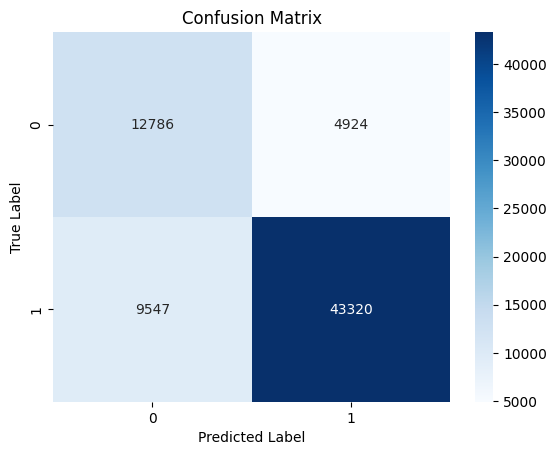

In [ ]:
conf_matrix = confusion_matrix(Y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=multinomialNB.classes_, yticklabels=multinomialNB.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**To print classification report**

In [ ]:
target_names = [str(cls) for cls in multinomialNB.classes_]
class_report = classification_report(Y_test, predictions, target_names=target_names)
print("\nClassification Report:\n", class_report)



Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.72      0.64     17710
           1       0.90      0.82      0.86     52867

    accuracy                           0.79     70577
   macro avg       0.74      0.77      0.75     70577
weighted avg       0.82      0.79      0.80     70577



**To get the ROC and AUC**

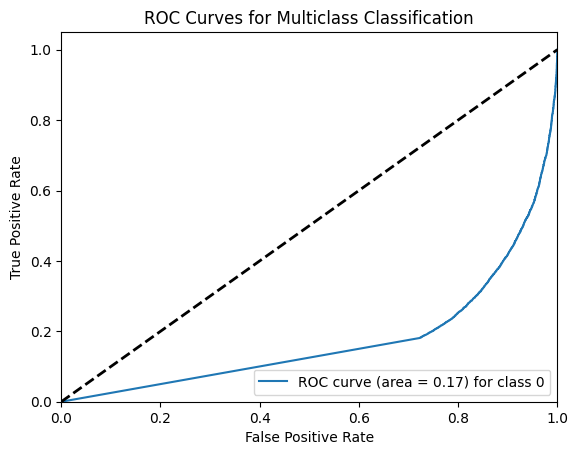

In [ ]:
Y_test_bin = label_binarize(Y_test, classes=multinomialNB.classes_)
n_classes = Y_test_bin.shape[1]

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(n_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(Y_test_bin[:, i], proba_predictions[:, i])
    roc_auc[i] = roc_auc_score(Y_test_bin[:, i], proba_predictions[:, i])

# to plot the ROC for each class
plt.figure()
for i in range(n_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {multinomialNB.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

**APPLICATION OF HYPERTUNING USING GRIDSEARCH**

**A function to perform hypertuning**

In [ ]:
def hypertune_multinomial_nb(X_train_main, Y_train_main, param_grid):
    grid_search = GridSearchCV(MultinomialNaiveBayes(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_main, Y_train_main)

    best_alpha = grid_search.best_params_['alpha']
    best_model = MultinomialNaiveBayes(alpha=best_alpha)
    best_model.fit(X_train_main, Y_train_main)

    return best_model, grid_search.best_params_, grid_search.best_score_


**Defining the parameter grid**

In [ ]:
param_grid = {'alpha': [0.5, 1.0, 1.5, 2.0]}

**To apply the hypertune function on the train data and print the best parameter and score**

In [ ]:
best_model, best_params, best_score = hypertune_multinomial_nb(X_train_main, Y_train_main, param_grid)

print("Best Parameters:", best_params)
print(f"Best CV Score: {best_score:.2f}")


Best Parameters: {'alpha': 0.5}
Best CV Score: 0.80


**To make predictions using the best model**

In [ ]:
predictions = best_model.predict(X_test)
proba_predictions = best_model.predict_proba(X_test)
print("Predictions:", predictions)

Predictions: [1 0 0 ... 1 1 1]


**To evaluate using the accuracy, precision, recall and f1-score metrics**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.80
Precision: 0.90
Recall: 0.83
F1 Score: 0.86


**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro Average**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='macro')
recall = recall_score(Y_test, predictions, average='macro')
f1 = f1_score(Y_test, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.80
Precision: 0.74
Recall: 0.77
F1 Score: 0.75


**To get the Confusion Matrix**

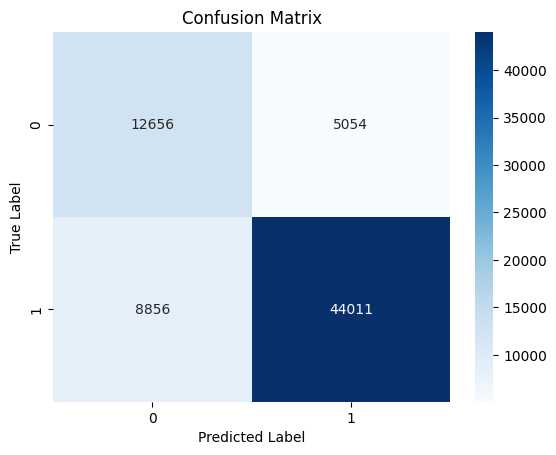

In [ ]:
conf_matrix = confusion_matrix(Y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**To print classification report**

In [ ]:
target_names = [str(cls) for cls in best_model.classes_]
class_report = classification_report(Y_test, predictions, target_names=target_names)
print("\nClassification Report:\n", class_report)



Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.71      0.65     17710
           1       0.90      0.83      0.86     52867

    accuracy                           0.80     70577
   macro avg       0.74      0.77      0.75     70577
weighted avg       0.82      0.80      0.81     70577



**To get the ROC and AUC**

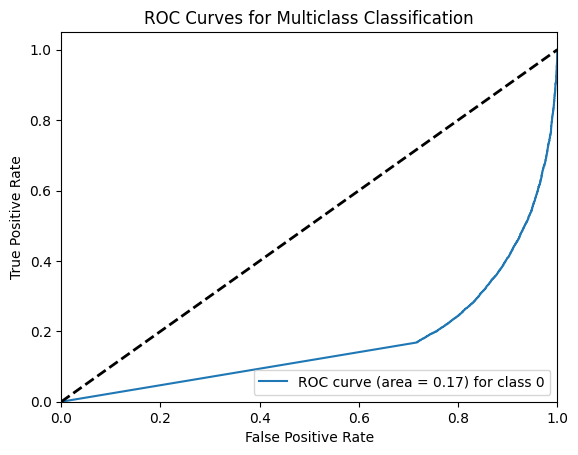

In [ ]:
Y_test_bin = label_binarize(Y_test, classes=best_model.classes_)
n_classes = Y_test_bin.shape[1]

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(n_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(Y_test_bin[:, i], proba_predictions[:, i])
    roc_auc[i] = roc_auc_score(Y_test_bin[:, i], proba_predictions[:, i])

# to plot the ROC for each class
plt.figure()
for i in range(n_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {best_model.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

**CHANGING THE PARAMETER GRID VALUES**

**Defining the parameter grid**

In [ ]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

**To apply the hypertune function on the train data and print the best parameter and score**

In [ ]:
best_model, best_params, best_score = hypertune_multinomial_nb(X_train_main, Y_train_main, param_grid)

print("Best Parameters:", best_params)
# print("Best CV Score:", best_score)
print(f"Best CV Score: {best_score:.2f}")

Best Parameters: {'alpha': 0.1}
Best CV Score: 0.81


**To make predictions using the best model**

In [ ]:
predictions = best_model.predict(X_test)
proba_predictions = best_model.predict_proba(X_test)
print("Predictions:", predictions)

Predictions: [1 0 0 ... 1 1 1]


**To evaluate using the accuracy, precision, recall and f1-score metrics**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.90
Recall: 0.85
F1 Score: 0.87


**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro Average**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='macro')
recall = recall_score(Y_test, predictions, average='macro')
f1 = f1_score(Y_test, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.75
Recall: 0.78
F1 Score: 0.76


**To get the Confusion Matrix**

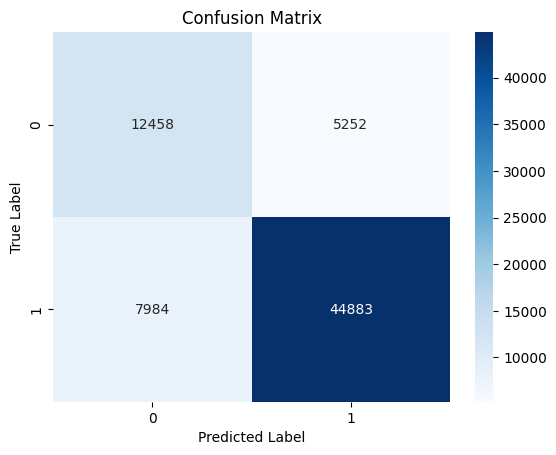

In [ ]:
conf_matrix = confusion_matrix(Y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**To print classification report**

In [ ]:
target_names = [str(cls) for cls in best_model.classes_]
class_report = classification_report(Y_test, predictions, target_names=target_names)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.70      0.65     17710
           1       0.90      0.85      0.87     52867

    accuracy                           0.81     70577
   macro avg       0.75      0.78      0.76     70577
weighted avg       0.82      0.81      0.82     70577



**To get the ROC and AUC**

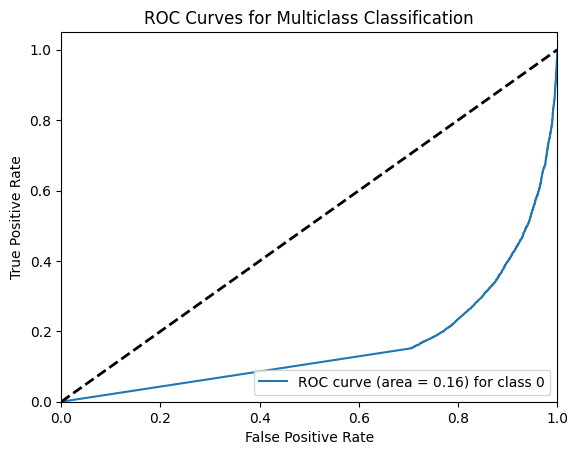

In [ ]:
Y_test_bin = label_binarize(Y_test, classes=best_model.classes_)
n_classes = Y_test_bin.shape[1]

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(n_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(Y_test_bin[:, i], proba_predictions[:, i])
    roc_auc[i] = roc_auc_score(Y_test_bin[:, i], proba_predictions[:, i])

# to plot the ROC for each class
plt.figure()
for i in range(n_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {best_model.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

**CHANGING THE PARAMETER GRID VALUES**

**Defining the parameter grid**

In [ ]:
param_grid = {'alpha': [0.05, 0.1, 0.5, 1.0, 1.5, 2.0]}

**To apply the hypertune function on the train data and print the best parameter and score**

In [ ]:
best_model, best_params, best_score = hypertune_multinomial_nb(X_train_main, Y_train_main, param_grid)

print("Best Parameters:", best_params)
print(f"Best CV Score: {best_score:.2f}")

Best Parameters: {'alpha': 0.05}
Best CV Score: 0.82


**To make predictions using the best model**

In [ ]:
predictions = best_model.predict(X_test)
proba_predictions = best_model.predict_proba(X_test)
print("Predictions:", predictions)

Predictions: [1 0 0 ... 1 1 1]


**To evaluate using the accuracy, precision, recall and f1-score metrics**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.89
Recall: 0.85
F1 Score: 0.87


**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro Average**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='macro')
recall = recall_score(Y_test, predictions, average='macro')
f1 = f1_score(Y_test, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.75
Recall: 0.78
F1 Score: 0.76


**To get the Confusion Matrix**

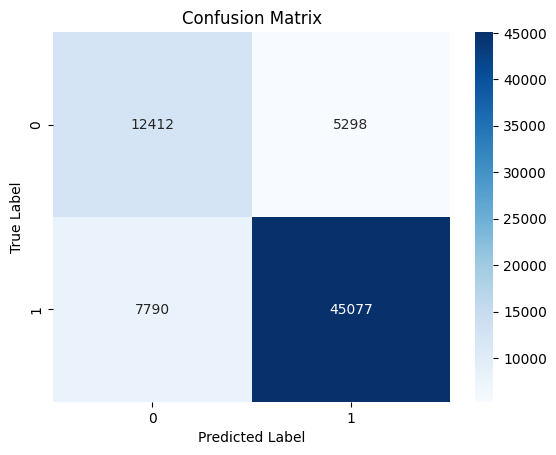

In [ ]:
conf_matrix = confusion_matrix(Y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**To print classification report**

In [ ]:
target_names = [str(cls) for cls in best_model.classes_]
class_report = classification_report(Y_test, predictions, target_names=target_names)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.70      0.65     17710
           1       0.89      0.85      0.87     52867

    accuracy                           0.81     70577
   macro avg       0.75      0.78      0.76     70577
weighted avg       0.82      0.81      0.82     70577



**To get the ROC and AUC**

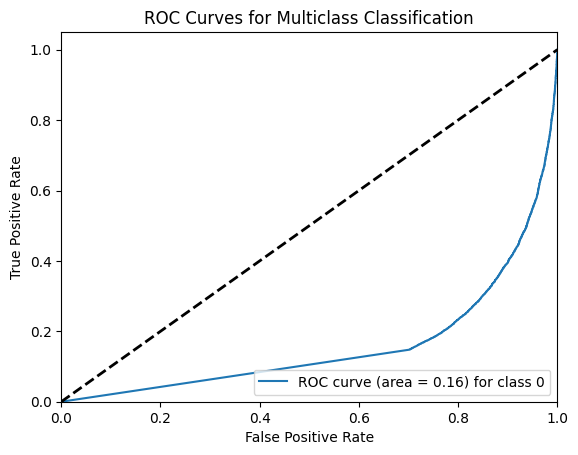

In [ ]:
Y_test_bin = label_binarize(Y_test, classes=best_model.classes_)
n_classes = Y_test_bin.shape[1]

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(n_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(Y_test_bin[:, i], proba_predictions[:, i])
    roc_auc[i] = roc_auc_score(Y_test_bin[:, i], proba_predictions[:, i])

# to plot the ROC for each class
plt.figure()
for i in range(n_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {best_model.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

**CHANGING THE PARAMETER GRID VALUES**

**Defining the parameter grid**

In [ ]:
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]}

**To apply the hypertune function on the train data and print the best parameter and score**

In [ ]:
best_model, best_params, best_score = hypertune_multinomial_nb(X_train_main, Y_train_main, param_grid)

print("Best Parameters:", best_params)
print(f"Best CV Score: {best_score:.2f}")

Best Parameters: {'alpha': 0.01}
Best CV Score: 0.82


**To predict using the best model**

In [ ]:
predictions = best_model.predict(X_test)
proba_predictions = best_model.predict_proba(X_test)
print("Predictions:", predictions)

Predictions: [1 0 0 ... 1 1 1]


**To evaluate using the accuracy, precision, recall and f1-score metrics**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.82
Precision: 0.89
Recall: 0.86
F1 Score: 0.87


**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro Average**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='macro')
recall = recall_score(Y_test, predictions, average='macro')
f1 = f1_score(Y_test, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.82
Precision: 0.76
Recall: 0.78
F1 Score: 0.76


**To get the Confusion Matrix**

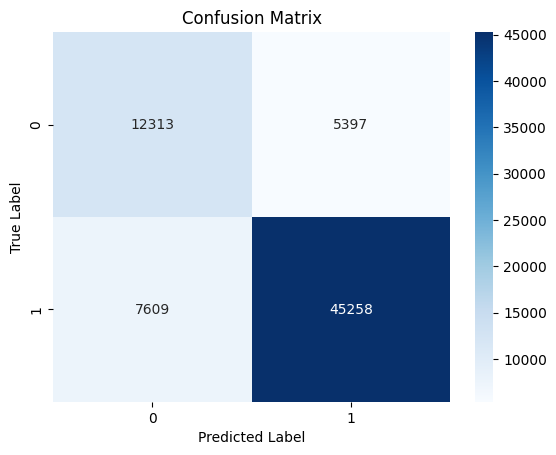

In [ ]:
conf_matrix = confusion_matrix(Y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**To print classification report**

In [ ]:
target_names = [str(cls) for cls in best_model.classes_]
class_report = classification_report(Y_test, predictions, target_names=target_names)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.65     17710
           1       0.89      0.86      0.87     52867

    accuracy                           0.82     70577
   macro avg       0.76      0.78      0.76     70577
weighted avg       0.82      0.82      0.82     70577



**To get the ROC and AUC**

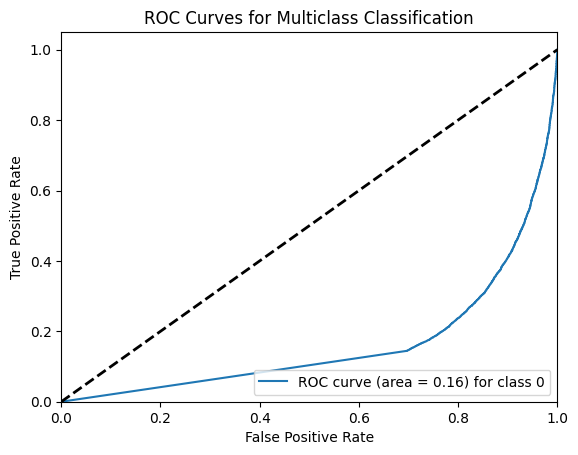

In [ ]:
Y_test_bin = label_binarize(Y_test, classes=best_model.classes_)
n_classes = Y_test_bin.shape[1]

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(n_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(Y_test_bin[:, i], proba_predictions[:, i])
    roc_auc[i] = roc_auc_score(Y_test_bin[:, i], proba_predictions[:, i])

# to plot the ROC for each class
plt.figure()
for i in range(n_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {best_model.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

**CHANGING THE PARAMETER GRID VALUES**

**To define the parameter grid**

In [ ]:
param_grid = {'alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]}

**To apply the hypertune function on the train data and print the best parameter and score**

In [ ]:
best_model, best_params, best_score = hypertune_multinomial_nb(X_train_main, Y_train_main, param_grid)

print("Best Parameters:", best_params)
print(f"Best CV Score: {best_score:.2f}")

Best Parameters: {'alpha': 0.005}
Best CV Score: 0.82


**To predict using the best model**

In [ ]:
predictions = best_model.predict(X_test)
proba_predictions = best_model.predict_proba(X_test)
print("Predictions:", predictions)

Predictions: [1 0 0 ... 1 1 1]


**To evaluate using the accuracy, precision, recall and f1-score metrics**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.82
Precision: 0.89
Recall: 0.86
F1 Score: 0.87


**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro Average**

In [ ]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average='macro')
recall = recall_score(Y_test, predictions, average='macro')
f1 = f1_score(Y_test, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.82
Precision: 0.76
Recall: 0.78
F1 Score: 0.76


**To get the Confusion Matrix**

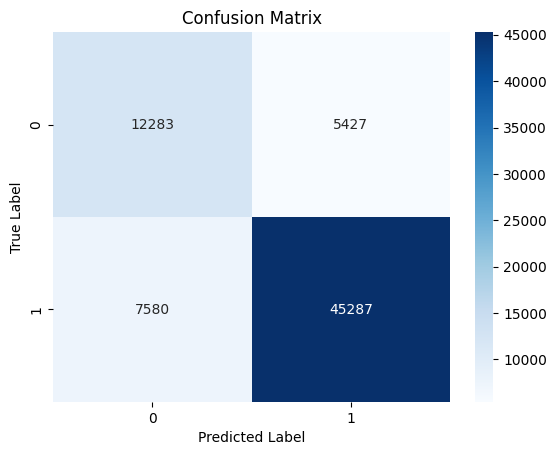

In [ ]:
conf_matrix = confusion_matrix(Y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**To print classification report**

In [ ]:
target_names = [str(cls) for cls in best_model.classes_]
class_report = classification_report(Y_test, predictions, target_names=target_names)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.69      0.65     17710
           1       0.89      0.86      0.87     52867

    accuracy                           0.82     70577
   macro avg       0.76      0.78      0.76     70577
weighted avg       0.82      0.82      0.82     70577



**To get the ROC and AUC**

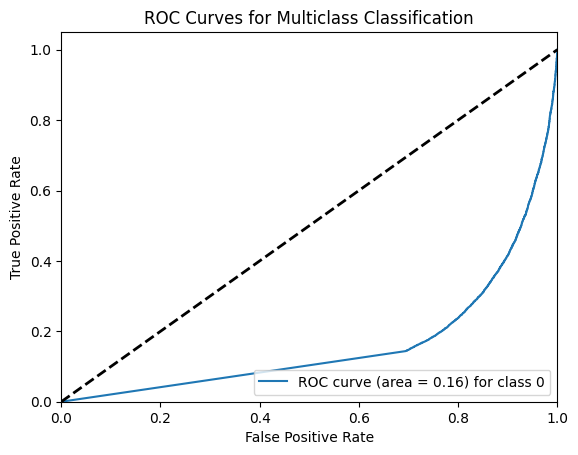

In [ ]:
Y_test_bin = label_binarize(Y_test, classes=best_model.classes_)
n_classes = Y_test_bin.shape[1]

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(n_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(Y_test_bin[:, i], proba_predictions[:, i])
    roc_auc[i] = roc_auc_score(Y_test_bin[:, i], proba_predictions[:, i])

# to plot the ROC for each class
plt.figure()
for i in range(n_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {best_model.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

**To save the model using pickle**

In [ ]:
import pickle

model_path = '/content/drive/MyDrive/Project_Dataset/model.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(best_model, file)

vectorizer_path = '/content/drive/MyDrive/Project_Dataset/vectorizer.pkl'

with open(vectorizer_path, 'wb') as file:
    pickle.dump(vectorizer, file)

print(f"Model saved to {model_path}")
print(f"Vectorizer saved to {vectorizer_path}")



Model saved to /content/drive/MyDrive/Project_Dataset/model.pkl
Vectorizer saved to /content/drive/MyDrive/Project_Dataset/vectorizer.pkl


**TO COMPARE MULTINOMIAL NAIVE BAYES AND RANDOMFORESTCLASSIFIER**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

**Visualization of the classifiers performance on 10,000 samples of datasets using different metrics**

In [ ]:
classifiers = ['Multinomial Naïve Bayes', 'Random Forest Classifier']
metrics = ['Accuracy', 'Precision', 'F1 Score', 'Recall', 'Specificity']

In [ ]:
MNB_Metrics_values = [0.74, 0.89, 0.81, 0.75, 0.70]
RFC_Metrics_values = [0.70, 0.81, 0.81, 0.81, 0.37]

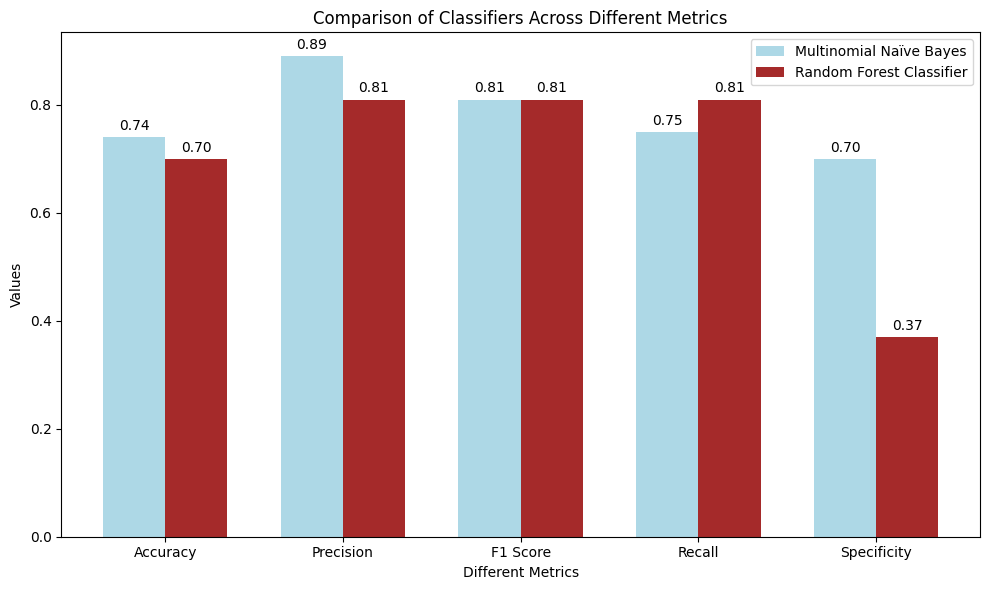

In [ ]:
x_axis = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x_axis - width/2, MNB_Metrics_values, width, label='Multinomial Naïve Bayes', color='lightblue')
bars2 = ax.bar(x_axis + width/2, RFC_Metrics_values, width, label='Random Forest Classifier', color='brown')
ax.set_xlabel('Different Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Classifiers Across Different Metrics')
ax.set_xticks(x_axis)
ax.set_xticklabels(metrics)
ax.legend()


def show_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

show_values(bars1)
show_values(bars2)

# Display the plot
plt.tight_layout()
plt.show()

**Visualization of the classifiers performance on 20,000 samples of datasets using different metrics.**

In [ ]:
classifiers = ['Multinomial Naïve Bayes', 'Random Forest Classifier']
metrics = ['Accuracy', 'Precision', 'F1 Score', 'Recall', 'Specificity']

In [ ]:
MNB_Metrics_values = [0.75, 0.89, 0.82, 0.77, 0.71]
RFC_Metrics_values = [0.70, 0.81, 0.80, 0.79, 0.42]

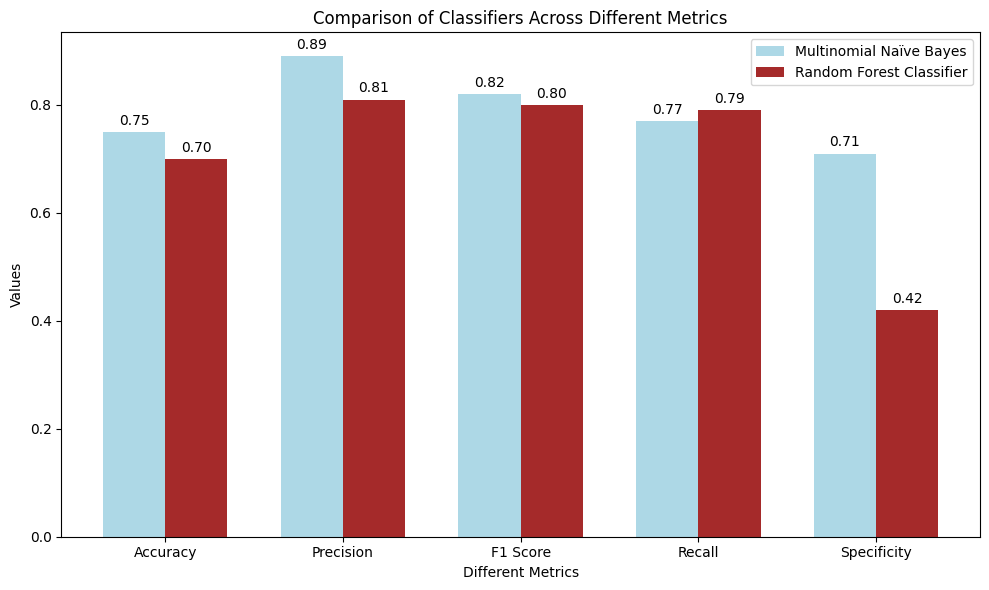

In [ ]:
x_axis = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x_axis - width/2, MNB_Metrics_values, width, label='Multinomial Naïve Bayes', color='lightblue')
bars2 = ax.bar(x_axis + width/2, RFC_Metrics_values, width, label='Random Forest Classifier', color='brown')
ax.set_xlabel('Different Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Classifiers Across Different Metrics')
ax.set_xticks(x_axis)
ax.set_xticklabels(metrics)
ax.legend()


def show_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

show_values(bars1)
show_values(bars2)

# Display the plot
plt.tight_layout()
plt.show()


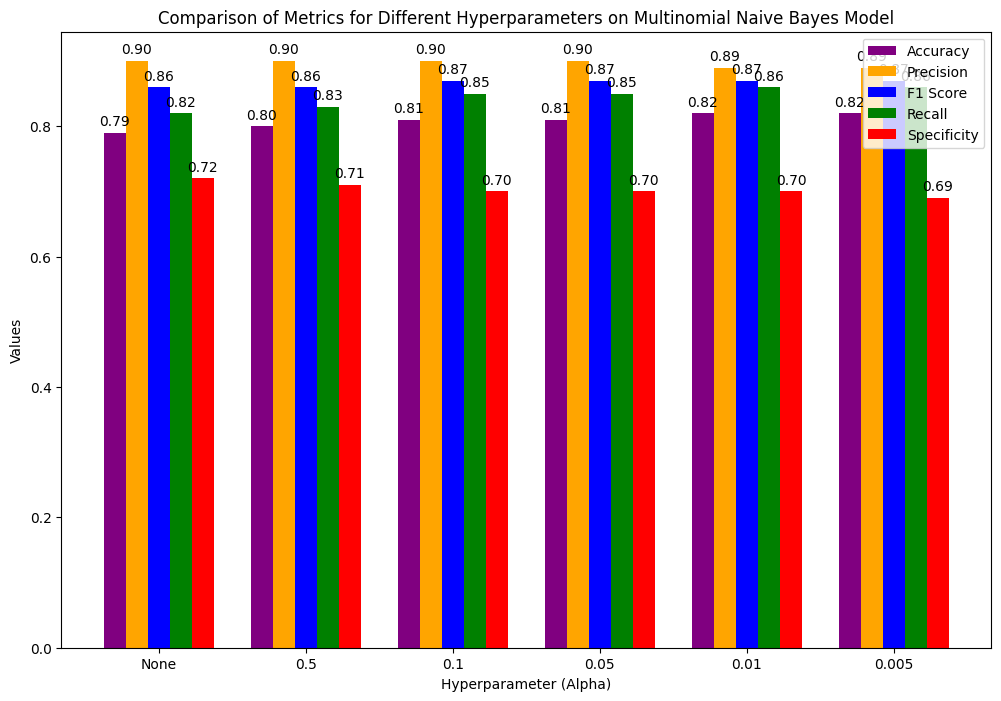

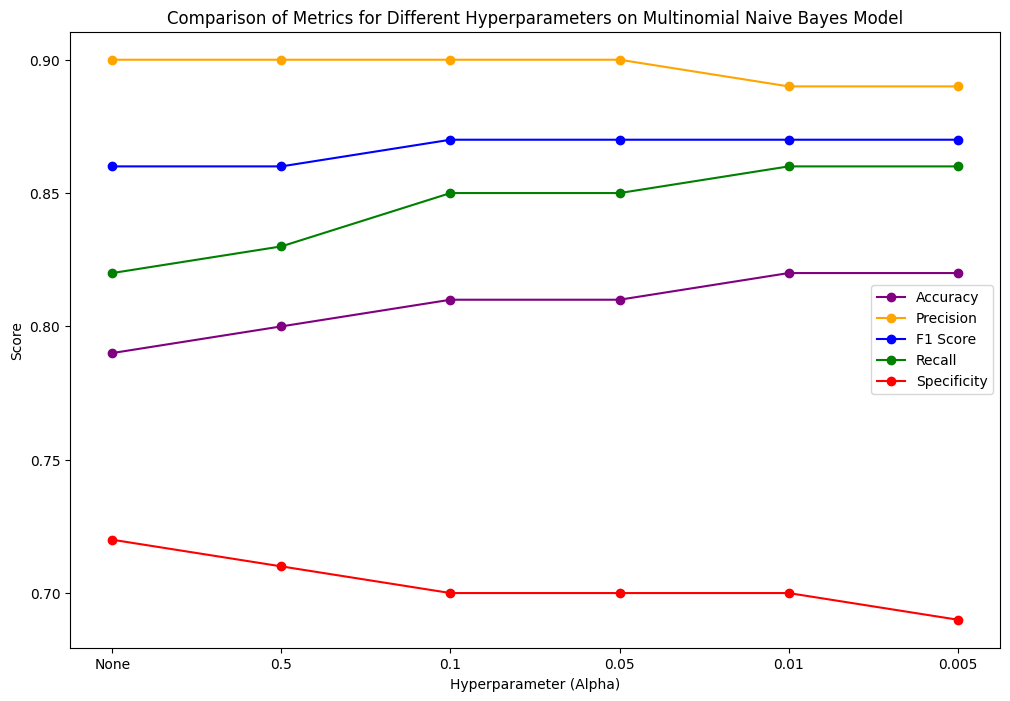

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
alpha = ['None', '0.5', '0.1', '0.05', '0.01', '0.005']
accuracy = [0.79, 0.80, 0.81, 0.81, 0.82, 0.82]
precision = [0.90, 0.90, 0.90, 0.90, 0.89, 0.89]
f1_score = [0.86, 0.86, 0.87, 0.87, 0.87, 0.87]
recall = [0.82, 0.83, 0.85, 0.85, 0.86, 0.86]
specificity = [0.72, 0.71, 0.70, 0.70, 0.70, 0.69]

x_axis = np.arange(len(alpha))

# # Plotting the bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.15
bar1 = plt.bar(x_axis - 2*bar_width, accuracy, width=bar_width, label='Accuracy', color='purple')
bar2 = plt.bar(x_axis - bar_width, precision, width=bar_width, label='Precision', color='orange')
bar3 = plt.bar(x_axis, f1_score, width=bar_width, label='F1 Score', color='blue')
bar4 = plt.bar(x_axis + bar_width, recall, width=bar_width, label='Recall', color='green')
bar5 = plt.bar(x_axis + 2*bar_width, specificity, width=bar_width, label='Specificity', color='red')
plt.xlabel('Hyperparameter (Alpha)')
plt.ylabel('Values')
plt.title('Comparison of Metrics for Different Hyperparameters on Multinomial Naive Bayes Model')
plt.xticks(x_axis, alpha)

def show_values(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

show_values(bar1)
show_values(bar2)
show_values(bar3)
show_values(bar4)
show_values(bar5)

plt.legend()
plt.show()

# Plotting the line chart
plt.figure(figsize=(12, 8))
plt.plot(alpha, accuracy, marker='o', label='Accuracy', color='purple')
plt.plot(alpha, precision, marker='o', label='Precision', color='orange')
plt.plot(alpha, f1_score, marker='o', label='F1 Score', color='blue')
plt.plot(alpha, recall, marker='o', label='Recall', color='green')
plt.plot(alpha, specificity, marker='o', label='Specificity', color='red')
plt.xlabel('Hyperparameter (Alpha)')
plt.ylabel('Score')
plt.title('Comparison of Metrics for Different Hyperparameters on Multinomial Naive Bayes Model')
plt.legend()
plt.show()


**Comparison of different model with the proposed best model**

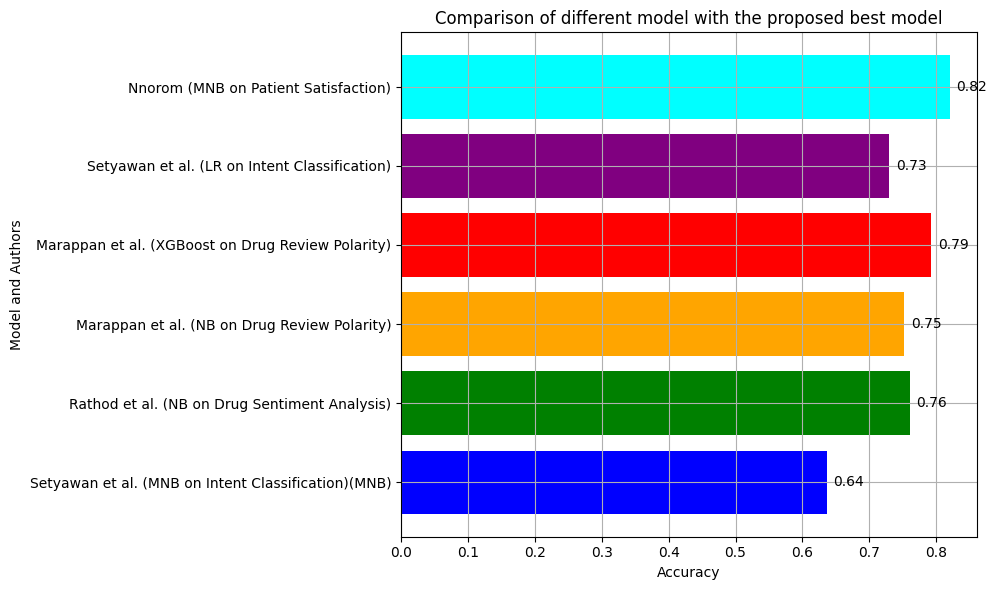

In [ ]:
import matplotlib.pyplot as plt

names_and_model= [
    'Setyawan et al. (MNB on Intent Classification)(MNB)',
    'Rathod et al. (NB on Drug Sentiment Analysis)',
    'Marappan et al. (NB on Drug Review Polarity)',
    'Marappan et al. (XGBoost on Drug Review Polarity)',
    'Setyawan et al. (LR on Intent Classification)',
    'Nnorom (MNB on Patient Satisfaction)'
]

accuracy = [0.6364, 0.76, 0.752, 0.792, 0.73, 0.82]

# Creating a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(names_and_model, accuracy, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])

# Adding labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,  f'{width:.2f}', va='center')

# Adding labels, title and displaying the plot:
plt.xlabel('Accuracy')
plt.ylabel('Model and Authors')
plt.title('Comparison of different model with the proposed best model')
plt.grid(True)
plt.tight_layout()
plt.show()




**Baseline Model (RFC) metrics analysis**

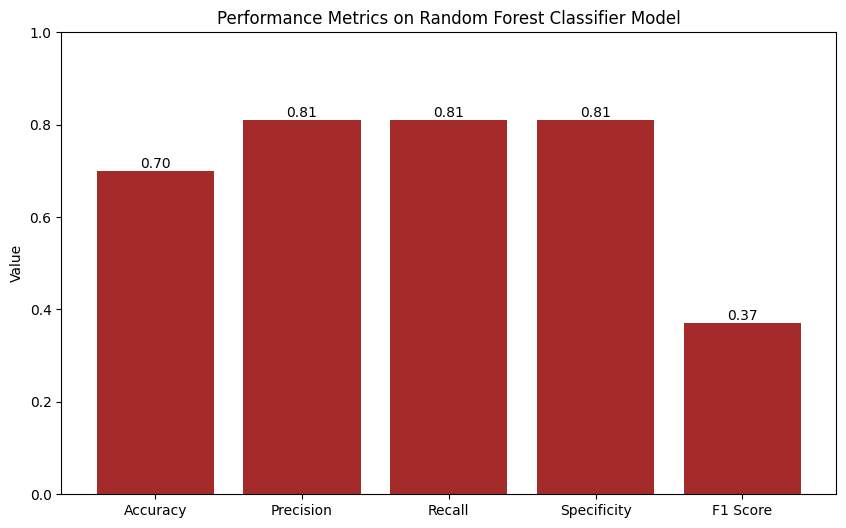

In [4]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
values = [0.70, 0.81, 0.81, 0.81, 0.37]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='brown')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')


plt.title('Performance Metrics on Random Forest Classifier Model')

plt.ylabel('Value')
plt.ylim(0, 1)

plt.show()


**Best Model (MNB) metrics analysis**

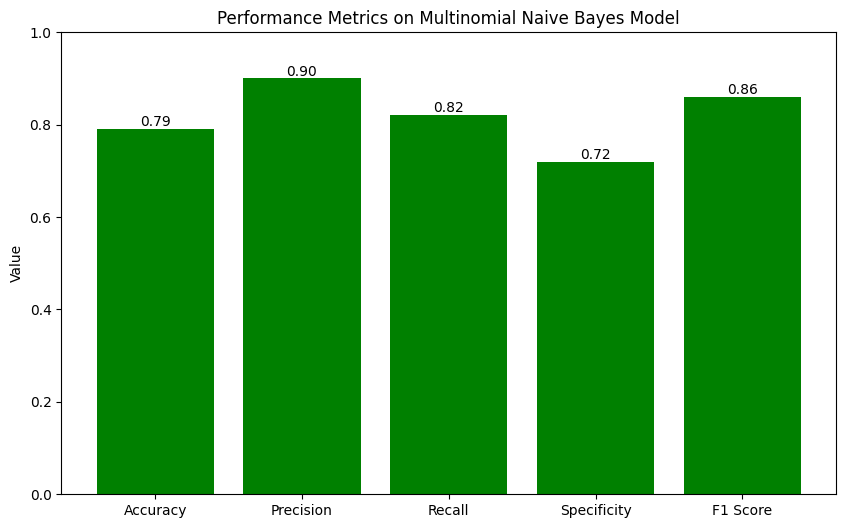

In [5]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
values = [0.79, 0.90, 0.82, 0.72, 0.86]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='Green')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')


plt.title('Performance Metrics on Multinomial Naive Bayes Model')

plt.ylabel('Value')
plt.ylim(0, 1)

plt.show()
